Part b of project. Use Ridge and OLS. Also use a neural network.

Importing different libraries and defining activation / cost functions.

In [11]:
import autograd.numpy as np  # We need to use this numpy wrapper to make automatic differentiation work later
from autograd import grad, elementwise_grad
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Defining some activation functions and their derivatives
def ReLU(z):
    return np.where(z > 0, z, 0)

def ReLU_der(z):
    return np.where(z > 0, 1, 0)

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_der(z):
    da_dz = sigmoid(z) * (1 - sigmoid(z))
    return da_dz

def mse(predict, target):
    return np.mean((predict - target) ** 2)

def mse_der(predict, target):
    dC_da = 2/len(target) * (predict - target)
    return dC_da

def R2(predict, target):
    return 1 - np.sum((target - predict) ** 2) / np.sum((target - np.mean(target)) ** 2)

def identity_function(z):
    return z

def identity_der(z):
    return 1


Defining our functions for our feed forward loop and back propagation. These are not batched as we use a simple one-dimensional example!

In [12]:
def create_layers(network_input_size, layer_output_sizes):
    layers = []

    i_size = network_input_size
    for layer_output_size in layer_output_sizes:
        W = np.random.randn(layer_output_size, i_size)
        b = np.random.randn(layer_output_size)
        layers.append((W, b))

        i_size = layer_output_size
    return layers

def feed_forward(input, layers, activation_funcs):
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        z = W @ a + b
        a = activation_func(z)
    return a

def cost(layers, input, activation_funcs, target):
    predict = feed_forward(input, layers, activation_funcs)
    return mse(predict, target)

def feed_forward_saver(input, layers, activation_funcs):
    layer_inputs = []
    zs = []
    a = input
    for (W, b), activation_func in zip(layers, activation_funcs):
        layer_inputs.append(a)
        z = W @ a + b
        a = activation_func(z)

        zs.append(z)

    return layer_inputs, zs, a

def backpropagation(
    input, layers, activation_funcs, target, activation_ders, cost_der=mse_der
):
    layer_inputs, zs, predict = feed_forward_saver(input, layers, activation_funcs)

    layer_grads = [() for layer in layers]

    # We loop over the layers, from the last to the first
    for i in reversed(range(len(layers))):
        layer_input, z, activation_der = layer_inputs[i], zs[i], activation_ders[i]

        if i == len(layers) - 1:
            # For last layer we use cost derivative as dC_da(L) can be computed directly
            dC_da = cost_der(predict, target)
        else:
            # For other layers we build on previous z derivative, as dC_da(i) = dC_dz(i+1) * dz(i+1)_da(i)
            (W, b) = layers[i + 1]
            dC_da = dC_dz @ W

        dC_dz = dC_da * activation_der(z)
        dC_dW = np.outer(dC_dz, layer_input)
        dC_db = dC_da * activation_der(z) * 1

        layer_grads[i] = (dC_dW, dC_db)

    return layer_grads

Generating data, and deciding the number of layers and output functions.

MSE for OLS: 3.024763881553529e-28
R2 for OLS: 1.0


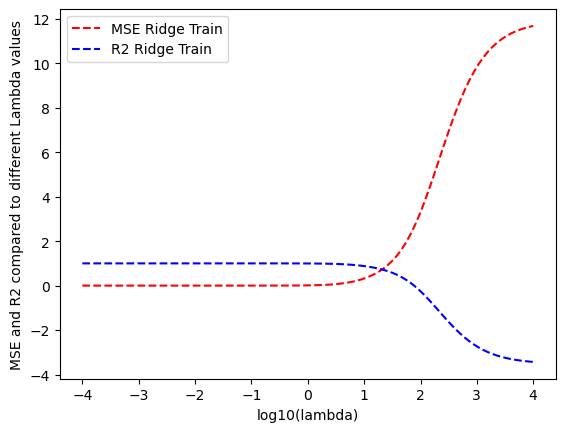

MSE for Ridge: 0.00037343459865159175
R2 for Ridge: 0.9998582891593671


In [13]:
np.random.seed(666)
x = np.random.rand(100)
#print("Our x-values:", x)
target = x**2 * 3 + x * 2 + 1
#print("Our target:", target)

X = np.ones((len(x), 3))
X[:,0] = 1
X[:,1] = x
X[:,2] = x**2

X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=0.2)
x_train, x_test = train_test_split(x, test_size=0.2)

#OLS
beta_ols = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ target_train
predict_ols = X_test @ beta_ols

#print("Our OLS prediction:", predict_ols)
print("MSE for OLS:", mse(predict_ols, target_test))
print("R2 for OLS:", R2(predict_ols, target_test))

#Ridge
I = np.eye(3, 3)
nlambdas = 100
mse_ridge = np.zeros(nlambdas)
r2_ridge = np.zeros(nlambdas)
lambdas = np.logspace(-4, 4, nlambdas)

for i in range(nlambdas):
    lmb = lambdas[i]
    beta_ridge = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ target_train
    # and then make the prediction
    predict_ridge = X_test @ beta_ridge
    mse_ridge[i] = mse(predict_ridge, target_test)
    r2_ridge[i] = R2(predict_ridge, target_test)

# Now plot the results
plt.figure()
plt.plot(np.log10(lambdas), mse_ridge, 'r--', label = 'MSE Ridge Train')
plt.plot(np.log10(lambdas), r2_ridge, 'b--', label = 'R2 Ridge Train')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE and R2 compared to different Lambda values')
plt.legend()
plt.show()

#Choose lambda accordingly
lmb = 10**-1
beta_ridge = np.linalg.inv(X_train.T @ X_train+lmb*I) @ X_train.T @ target_train
predict_ridge = X_test @ beta_ridge

#print("Our Ridge prediction:", predict_ridge)
print("MSE for Ridge:", mse(predict_ridge, target_test))
print("R2 for Ridge:", R2(predict_ridge, target_test))

#FFNN
network_input_size = X_test.shape[0]
layer_output_sizes = [3, 2, len(X_test)]
activation_funcs = [sigmoid, sigmoid, identity_function]
activation_ders = [sigmoid_der, sigmoid_der, identity_der]

layers = create_layers(network_input_size, layer_output_sizes)

layer_grads = backpropagation(x_test, layers, activation_funcs, target_test, activation_ders)
#print(layer_grads)

Comparing with autograd (this gives the same result). So we use our own function in the network training.

In [14]:
'''cost_grad = grad(cost, 0)
cost_grad(layers, x, activation_funcs, target)'''

'cost_grad = grad(cost, 0)\ncost_grad(layers, x, activation_funcs, target)'

Now with updated W_g and b_g, we train the network.

In [15]:
def train_network(x, layers, activation_funcs, target, learning_rate=0.1, epochs=10):
    for i in range(epochs):
        layers_grad = backpropagation(x, layers, activation_funcs, target, activation_ders)
        for (W, b), (W_g, b_g) in zip(layers, layers_grad):
            W -= learning_rate * W_g
            b -= learning_rate * b_g

We see that the MSE decreases with increasing number of runs. Goes to zero, so with multiple runs the NN gives the same result as OLS and Ridge.

First NN MSE (Linear): 11.646589337411124
Last NN MSE (Linear): 0.00032294018506208986
First NN R2 (Linear): -3.4196439523000866
Last NN R2 (Linear): 0.9998774507630934


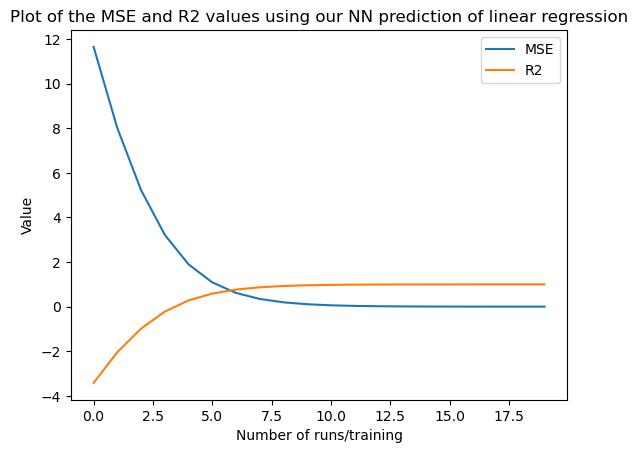

In [16]:
mse_nn = []
r2_nn = []
predics = []

n_iterations = len(x_test)

for i in range(n_iterations):
    train_network(x_test, layers, activation_funcs, target_test)
    prediction = feed_forward(x_test, layers, activation_funcs)
    predics.append(prediction)
    mse_val = mse(prediction, target_test)
    r2_val = R2(prediction, target_test)
    mse_nn.append(mse_val)
    r2_nn.append(r2_val)

#print("Our FFNN prediction:", prediction)
print("First NN MSE (Linear):", mse_nn[0])
print("Last NN MSE (Linear):", mse_nn[-1])
print("First NN R2 (Linear):", r2_nn[0])
print("Last NN R2 (Linear):", r2_nn[-1])

plt.plot(range(n_iterations), mse_nn, label="MSE")
plt.plot(range(n_iterations), r2_nn, label = "R2")
plt.title("Plot of the MSE and R2 values using our NN prediction of linear regression")
plt.xlabel("Number of runs/training")
plt.ylabel("Value")
plt.legend()
plt.show()